In [206]:
import itertools #iteration tools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # nice plots
import matplotlib.pyplot as plt # plots
from ipy_table import *

#preprocessing
from sklearn.preprocessing import LabelEncoder

# machine learning
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [207]:
##CHECK THOSEOUT
from imblearn.over_sampling import SMOTE
#import xgboost

### Get train Data

In [208]:
train_df = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/train.csv')
test_df = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/test.csv')
both = [train_df, test_df]
train_df.head()
super_table=[]
super_table.append(['name', 'reg_function', 'trainset_acc', 'testset_acc', 'r2score', 'conf_matrx', 'kaggle_acc'])
df_load = pd.read_csv(r'C:/Users/ernest.chocholowski/Desktop/GIT/Titanic/table_eCh.csv')
for row in df_load.values.tolist():
    super_table.append(row)

In [209]:
for df in both:
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess', 'Don', 'Dr', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Capt', 'Col', 'Major'], 'Officer')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

In [68]:
#labelling
var_mod = ['Title', 'Sex', 'Ticket', 'Embarked']
le = LabelEncoder()
for i in var_mod:
    mask = ~train_df[i].isnull()
    train_df[i][mask] = le.fit_transform(train_df[i][mask])
    mask2 = ~test_df[i].isnull()
    test_df[i][mask2] = le.fit_transform(test_df[i][mask2])

In [69]:
train_df = train_df.drop(['Cabin', 'Name', 'PassengerId'], axis=1)
test_df = test_df.drop(['Cabin', 'Name'], axis=1)

In [70]:
#Probabilities of each age in dataset :>
#kek=train_df.groupby(['Sex', 'Pclass', 'Title']).Age.apply(lambda g: g.value_counts()/len(g))

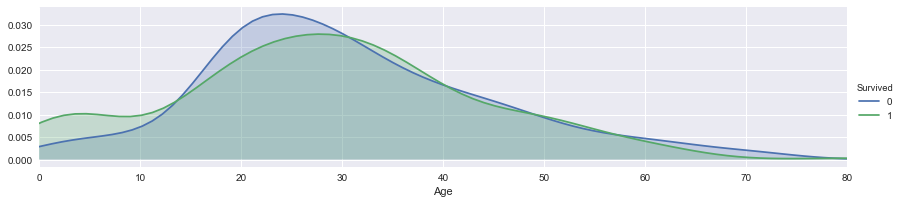

In [71]:
facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
facet.map(sns.kdeplot,'Age',shade= True)
facet.set(xlim=(0, train_df['Age'].max()))
facet.add_legend()
plt.show()

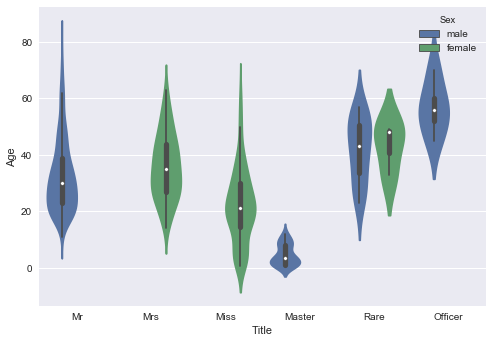

In [214]:
sns.violinplot(x="Title", y="Age", hue="Sex", data=train_df);
plt.show()

In [72]:
#perform imputation!
#imputation of age with imputer
from sklearn.preprocessing import Imputer
imp=Imputer(missing_values="NaN", strategy="mean" )
train_df["Age"]=imp.fit_transform(train_df[["Age"]]).ravel()
test_df["Age"]=imp.fit_transform(test_df[["Age"]]).ravel()

#impute embarked as the most frequent one
freq_port = train_df.Embarked.dropna().mode()[0]
train_df['Embarked'] = train_df['Embarked'].fillna(freq_port)

#impute missing Fare value
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

In [123]:
#Split data for train and test
def split_data(data, target='Survived'):
    #set target for training
    target = data["Survived"]

    # Import the train_test_split method
    from sklearn.model_selection import train_test_split
    # Split data into train (2/3rd of data) and test (1/3rd of data)
    return train_test_split(data, target, train_size = 0.75, random_state=0);

In [75]:
def regr_equation(logreg, train, target):
    if type(model) is LogisticRegression:
        coef = logreg.coef_[0]
        intercept = "{:.2f}".format(logreg.intercept_[0])
    else:
        coef = logreg.coef_
        intercept = "{:.2f}".format(logreg.intercept_)
        
    output = target.name + ' = ' + str(intercept) + ' + '
    coeff_df = pd.DataFrame(train.columns.delete(0))
    coeff_df.columns = ['Feature']
    coeff_df["Correlation"] = pd.Series(logreg.coef_[0])
    features = coeff_df['Feature'].tolist()
    coefficients = coeff_df['Correlation'].tolist()
    
    for coeff, feature in zip(coefficients, features):
        coeff_str = "{:.2f}".format(coeff)
        output += coeff_str + "*" + str(feature) + " + "
    return output[:-3]

In [76]:
def confusion_matrix(model, X, y):
    from sklearn.metrics import confusion_matrix
    return confusion_matrix(y, model.predict(X))

In [146]:
def test_model (model, data, submission_name = None, test=None):
   
    if test is None:
        
        from sklearn.metrics import accuracy_score, confusion_matrix, r2_score
        train, test, target_train, target_test = split_data(data)
        model.fit(train, target_train)
        #Calc parameters
        if type(model) is LogisticRegression:
            function_str = regr_equation(model, train, target_train)
        elif type(model) is LinearRegression:
            function_str = regr_equation(model, train, target_train)
        else :
            function_str = "NA"    

        if type(model) is not LinearRegression:
            trainset_acc = round(accuracy_score(target_train, model.predict(train)) * 100, 2)
            testset_acc = round(accuracy_score(target_test, model.predict(test)) * 100, 2)
            conf_matrix = confusion_matrix(target_train, model.predict(train))
            conf_matrix = 'TN: '+str(conf_matrix[0][0])+', FP: '+str(conf_matrix[0][1])+ \
                              ', FN: '+str(conf_matrix[1][0])+', TP: '+str(conf_matrix[1][1])
        else:
            trainset_acc = 'NA'
            testset_acc = 'NA'
            conf_matrix = "NA"

        r2_score = r2_score(target_train, model.predict(train))
        kaggle = "not_tested"

        #prints
        print("-"*40)
        print('Submission name:', submission_name )
        print('Regression function:\n', function_str)
        print('Accuracy on train set:', trainset_acc)
        print('Accuracy on test set:', testset_acc)
        print("R2 score:", r2_score)
        print("Confusion matrix:\n", conf_matrix)
        return [submission_name, function_str, str(trainset_acc), str(testset_acc), r2_score, conf_matrix, kaggle]
    else:
        
        train = data.drop("Survived", axis=1)
        target_train = data["Survived"]
        if 'PassengerId' in test:
            test  = test.drop("PassengerId", axis=1).copy()
        model.fit(train, target_train)
        pred = model.predict(test)
        
        submission = pd.DataFrame({
                "PassengerId": test_df["PassengerId"],
                "Survived": pred
            })
        submission.to_csv(r'C:/Users/ernest.chocholowski/Desktop/Datasets/Titanic/output/'+submission_name+'.csv',
                          index=False)
    

In [147]:
#Setup
suffix = '_advancedFeatureSelection'
from sklearn.neural_network import MLPClassifier
modelMLP = MLPClassifier()
modelLogReg = LogisticRegression()
modelLinReg = LinearRegression()
modelSVC = SVC()
modellinSVC = LinearSVC()
modelKN = KNeighborsClassifier(n_neighbors = 3)
modelGNB = GaussianNB()
modelPercp = Perceptron()
modelSGD = SGDClassifier()
modelTree = DecisionTreeClassifier()
modelRndForest = RandomForestClassifier()

modelXTree = ExtraTreesClassifier()

models = {modelLogReg: "LogisticRegr", modelLinReg: "LinearRegr",
          modelSVC: "SVC", modellinSVC: "LinSVC",
          modelKN: "KN", modelGNB: "GaussianNB",
          modelPercp: "Percep", modelMLP: "MLPercep",
          modelSGD: "SGD", modelXTree: "XTree",
          modelTree: "DecisionTree", modelRndForest: "RandomForest"
         }

In [148]:
outputs = []
for model, prefix in models.items():
    name=prefix+suffix
    outputs.append(test_model(model, train_df, submission_name=name))
outputs.sort(key=lambda x: x[0])

----------------------------------------
Submission name: LogisticRegr_advancedFeatureSelection
Regression function:
 Survived = -0.68 + 6.95*Pclass + -0.64*Sex + -1.06*Age + -0.01*Parch + 0.18*Fare + -0.13*Embarked + 0.03*Name_length + -0.01*Has_Cabin + -0.07*FamilySize + -0.31*IsAlone + -0.53*Title
Accuracy on train set: 100.0
Accuracy on test set: 100.0
R2 score: 1.0
Confusion matrix:
 TN: 410, FP: 0, FN: 0, TP: 258
----------------------------------------
Submission name: KN_advancedFeatureSelection
Regression function:
 NA
Accuracy on train set: 93.26
Accuracy on test set: 85.2
R2 score: 0.715825297788
Confusion matrix:
 TN: 390, FP: 20, FN: 25, TP: 233
----------------------------------------
Submission name: MLPercep_advancedFeatureSelection
Regression function:
 NA
Accuracy on train set: 100.0
Accuracy on test set: 100.0
R2 score: 1.0
Confusion matrix:
 TN: 410, FP: 0, FN: 0, TP: 258
----------------------------------------
Submission name: SGD_advancedFeatureSelection
Regressi

In [149]:
# DecisionTree_basicTest
# GaussianNB_basicTest
# KN_basicTest
# LinSVC_basicTest
# Percep_basicTest
# RandomForest_basicTest
# SGD_basicTest
# SVC_basicTest

In [152]:
models = {
         modelLogReg: "LogisticRegr", modelGNB: "GaussianNB",
         modelTree: "DecisionTree", modelMLP: "MLPercep",
         modelRndForest: "RandomForest", modelXTree: "XTree",
         modelSVC: "SVC"
         }

for model, prefix in models.items():
    name=prefix+suffix
    test_model(model, train_df, submission_name=name, test=test_df)

In [153]:
for out in outputs:
    super_table.append(out)

In [192]:
make_table(super_table)
apply_theme('basic')

name,reg_function,trainset_acc,testset_acc,r2score,conf_matrx,kaggle_acc
logisticReg_basic,Survived = 3.99 + -0.85*Pclass + -0.00*Name + -2.35*Sex + -0.03*Age + -0.32*SibSp + -0.06*Parch + -0.00*Ticket + 0.01*Fare,79.97,nan,0.169632400781,"TN: 369, FP: 55, FN: 88, TP: 202",failed_evl
linearReg_basic,Survived = 1.40 + -0.19*Pclass + -0.00*Name + -0.49*Sex + -0.01*Age + -0.06*SibSp + -0.01*Parch + -0.00*Ticket + 0.00*Fare,40.25,nan,0.402525234523,nan,failed_evl
SVC_basic,nan,99.86,nan,0.994193233572,"TN: 424, FP: 0, FN: 1, TP: 289",failed_evl
KNC_basic,nan,82.49,nan,0.274154196487,"TN: 356, FP: 68, FN: 57, TP: 233",failed_evl
GaussianNB_basic,nan,78.57,nan,0.1115647365,"TN: 352, FP: 72, FN: 81, TP: 209",failed_evl
Perceptron_basic,nan,62.46,nan,-0.556213402733,"TN: 417, FP: 7, FN: 261, TP: 29",failed_evl
LinearSVC_basic,nan,49.44,nan,-1.09624268055,"TN: 94, FP: 330, FN: 31, TP: 259",failed_evl
SGDClassifier_basic,nan,65.69,nan,-0.422657774886,"TN: 330, FP: 94, FN: 151, TP: 139",failed_evl
DecisionTreeClassifier_basic,nan,100.0,nan,1.0,"TN: 424, FP: 0, FN: 0, TP: 290",failed_evl
RandomForestClassifier_basic,nan,100.0,nan,1.0,"TN: 424, FP: 0, FN: 0, TP: 290",failed_evl


In [195]:
#df = pd.DataFrame(super_table[1:], columns=super_table[0])
#df.to_csv(r'C:/Users/ernest.chocholowski/Desktop/GIT/Titanic/table_eCh.csv', 
#                      index=False)

In [45]:
from sklearn.model_selection import KFold
model = modelRndForest

#Simple K-Fold cross validation. 10 folds.
cv = KFold(n_splits=10)